# Inference notenook for [CLIP prefix captioning](https://github.com/rmokady/CLIP_prefix_caption/)

Disclaimer: the authors do not own any rights for the code or data.

In [1]:
#@title Install
! pip install transformers
! pip install git+https://github.com/openai/CLIP.git

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-d97v6pj8
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-d97v6pj8
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [1]:
import numpy as np

# Create a 3-dimensional array
sorted_indices_to_remove = np.random.randint(0, 10, size=(3, 4, 5))
print("Original array:")
print(sorted_indices_to_remove.shape)
print()

# Select elements from all dimensions except the last one,
# starting from the second element along the last dimension
selected_elements = sorted_indices_to_remove[..., 2:]
print("Selected elements:")
print(selected_elements.shape)

Original array:
(3, 4, 5)

Selected elements:
(3, 4, 3)


In [6]:
#@title Imports
import clip, json
import os, sys
from torch import nn
import numpy as np
import torch, nltk
import torch.nn.functional as nnf
from typing import Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score, single_meteor_score
from tqdm import tqdm, trange
import skimage.io as io
import PIL.Image
import pickle
from IPython.display import Image 
#nltk.download('wordnet')
#nltk.download('punkt')


D = torch.device
CPU = torch.device('cpu')

def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'weights_mlp.pt')
model_path1 = "/home/apassadaki/data/admitosstorage/pretrained_models/MLP_prefix/coco_prefix-009.pt"
model_path2 = "/home/apassadaki/data/admitosstorage/pretrained_models/MLP_prefix_GPT/coco_prefix-009.pt"

nice


In [3]:
#@title Model

class MLP(nn.Module):

    def __init__(self, sizes, bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class ClipCaptionModel(nn.Module):

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length)//2, self.gpt_embedding_size * prefix_length))

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D):
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens, prefix, mask = None, labels = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [4]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int=5, prompt=None, embed=None, entry_length=67, temperature=1., stop_token: str='.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped,0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(model, tokenizer, tokens=None, prompt=None, embed=None,
        entry_count=1, entry_length=67,  # maximum number of words
        top_p=0.8, temperature=1., stop_token: str='.',): 
    
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:,-1,:]/(temperature if temperature>0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [5]:
#@title GPU/CPU
is_gpu = True #@param {type:"boolean"}  

In [6]:
#@title CLIP model + GPT2 tokenizer
device = CUDA(0) if is_gpu else "cpu"
print(device)
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

cuda:0


In [10]:
#@title Load model weights
# The pretrained model was saved with ViT-B/32 image encoder and the parameters: prefix_length=10, (no clip_length) and prefix_size=512.
prefix_length = 10
model = ClipCaptionModel(prefix_length)
weights_mlp = torch.load(model_path1, map_location=CPU)
model.load_state_dict(weights_mlp) 
model = model.eval() 
model = model.to(device)

Conceptual captions examples:
https://drive.google.com/file/d/1mzH3b0LQrGEWjEva4hI6HE_fIYRIgtBT/view?usp=sharing

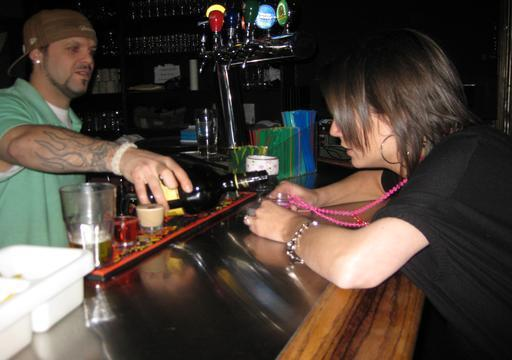

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



A man is playing a game of "Crazy" on a table.


In [12]:
#@title Inference
use_beam_search = False #@param {type:"boolean"}  
my_img_path = "/data/admitosstorage/yingjin_images" + "/image_100.jpg"
image = io.imread(my_img_path)
pil_image = PIL.Image.fromarray(image)
display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    # if type(model) is ClipCaptionE2E:
    #     prefix_embed = model.forward_image(image)
    # else:
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
else:
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)


print('\n')
print(generated_text_prefix)

In [13]:
path_to_test_dii = '/data/admitosstorage/DII-annotation/test.description-in-isolation.json'
with open(path_to_test_dii, 'r', encoding='utf-8') as f:
    test_data = json.load(f)['annotations']

path_to_val_dii = '/data/admitosstorage/DII-annotation/val.description-in-isolation.json'
with open(path_to_val_dii, 'r', encoding='utf-8') as f:
    val_data = json.load(f)['annotations']
    
path_to_train_dii = '/data/admitosstorage/DII-annotation/train.description-in-isolation.json'
with open(path_to_train_dii, 'r', encoding='utf-8') as f:
    train_data = json.load(f)['annotations']

In [14]:
folder_path = '/data/admitosstorage/test_images/'
test_dicts = []
train_dicts = []
val_dicts = []
for i,filename in enumerate(os.listdir(folder_path)):
    if filename.endswith(".jpg"):
        my_img_path = os.path.join(folder_path,filename)
        flag_test = False
        # flag_val = False
        # flag_train = False
        for my_item in test_data:
            if my_item[0]['photo_flickr_id'] == filename[:-4]:
                test_dicts.append(my_item[0])
        if not flag_test:
            print("We did not found the image on the TEST Set: ", filename)

    if i%100==0:
        print("On iteration {}:".format(i))
        print("-------------------------------------------------------------------------------------------------------------------------------")
        print("The length of the test_dicts is:", len(test_dicts))
        print("-------------------------------------------------------------------------------------------------------------------------------")
        print()

We did not found the image on the TEST Set:  10125768854.jpg
On iteration 0:
-------------------------------------------------------------------------------------------------------------------------------
The length of the test_dicts is: 0
-------------------------------------------------------------------------------------------------------------------------------

We did not found the image on the TEST Set:  10125833745.jpg
We did not found the image on the TEST Set:  10125853125.jpg
We did not found the image on the TEST Set:  10125871905.jpg
We did not found the image on the TEST Set:  10125874236.jpg
We did not found the image on the TEST Set:  10125941016.jpg
We did not found the image on the TEST Set:  10125952003.jpg
We did not found the image on the TEST Set:  10125972323.jpg
We did not found the image on the TEST Set:  10125979553.jpg
We did not found the image on the TEST Set:  10125983463.jpg
We did not found the image on the TEST Set:  10125986403.jpg
We did not found the 

In [15]:
my_original_dict = {}
flicker_ids = [item['photo_flickr_id'] for item in test_dicts]
print(len(flicker_ids))
unique_flicker_ids = list(set(flicker_ids))
print(len(unique_flicker_ids))
for id in unique_flicker_ids:
    my_original_dict[id] = [item['original_text'] for item in test_dicts if item['photo_flickr_id']==id] 

14976
4992


In [16]:
print(len(my_original_dict))
print(my_original_dict['10393317944'])
print(my_original_dict['10125853125'])
#print(my_original_dict.keys())

4992
['A older statue of a nautical fisherman, seated on a brick wall on a sidewalk.', 'A man is sitting on a brick wall in a blue costume, his hands and his face are blue', 'A street performer rests during a busy afternoon.']
["A stone statue of person's face with long hair", 'A light colored statue of a face has a solemn appearance.', 'A bust of someone made out of what appears to be marble.']


In [17]:
use_beam_search = True #@param {type:"boolean"} 
my_generated_dict = {}
for i, filename in enumerate(os.listdir(folder_path)):
    if i == 19483:
        continue
    else:
        if filename[:-4] not in my_original_dict.keys():
            print("Iteration: {} --> The image with photo_id: {}, has not be found".format(i,filename))
            continue 
        if filename.endswith(".jpg"):  
            my_img_path = os.path.join(folder_path,filename)
            
            image = io.imread(my_img_path)
            pil_image = PIL.Image.fromarray(image)
            # display(pil_image)
    
            image = preprocess(pil_image).unsqueeze(0).to(device)
            with torch.no_grad():
                prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
                prefix = prefix/prefix.norm(2,-1).item()
                prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
            if use_beam_search:
                generated_caption = generate_beam(model, tokenizer, embed=prefix_embed)[0]
            else:
                generated_caption = generate2(model, tokenizer, embed=prefix_embed)
    
            print("Iteration: {} --> For the image with photo_id: {}, the generated caption is: {}".format(i,filename,generated_caption))
            my_generated_dict[filename[:-4]] = generated_caption

Iteration: 0 --> The image with photo_id: 10125768854.jpg, has not be found
Iteration: 1 --> For the image with photo_id: 10125833745.jpg, the generated caption is:  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
Iteration: 2 --> For the image with photo_id: 10125853125.jpg, the generated caption is:  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
Iteration: 3 --> For the image with photo_id: 10125871905.jpg, the generated caption is:  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
Iteration: 4 --> The image with photo_id: 10125874236.jpg, has not be found
Iteration: 5 --> The image with photo_id: 10125941016.jpg, has not be found
Iteration: 6 --> The image with photo_id: 10125952003.jpg, has not be found
Iteration: 7 --> The image with photo_id: 10125972323.

KeyboardInterrupt: 

In [33]:
print(len(my_generated_dict))
#unique_flicker_ids.remove('764378')
print(len(unique_flicker_ids))
#my_original_dict.pop('764378')
print(len(my_original_dict))

4992
4992
4992


In [34]:
results_path1 = '/data/admitosstorage/results/zero-shot/MLP/original_dict.json'
results_path2 = '/data/admitosstorage/results/zero-shot/MLP/generated_dict_with_beam.json'

with open(results_path1, 'w', encoding='utf-8') as json_file:
    json.dump(my_original_dict, json_file, ensure_ascii=False, indent=4)

with open(results_path2, 'w', encoding='utf-8') as json_file:
    json.dump(my_generated_dict, json_file, ensure_ascii=False, indent=4)
    

In [35]:
## These scores are from the MLP model with the use of beam_search
chencherry  = nltk.translate.bleu_score.SmoothingFunction()
for j, id in enumerate(unique_flicker_ids):
    b_score = round(sentence_bleu(my_original_dict[id], my_generated_dict[id], weights=(1, 0, 0, 0),smoothing_function=chencherry.method1),5)
    print('On iteration {}, BLEU-1 score -> {}'.format(j,b_score))
    b_score = round(sentence_bleu(my_original_dict[id], my_generated_dict[id], weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1),5)
    print('On iteration {}, BLEU-2 score -> {}'.format(j,b_score))
    b_score = round(sentence_bleu(my_original_dict[id], my_generated_dict[id], weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=chencherry.method1),5)
    print('On iteration {}, BLEU-4 score -> {}'.format(j,b_score))
    #splitted_list = [item.split() for item in my_original_dict[id]]
    #m_score = round(meteor_score(splitted_list, my_generated_dict[id].split()),5)
    #print(f"On iteration {j}, METEOR-score -> {m_score}")
    print()


On iteration 0, BLEU-1 score -> 0.38835
On iteration 0, BLEU-2 score -> 0.29592
On iteration 0, BLEU-4 score -> 0.1676

On iteration 1, BLEU-1 score -> 0.78652
On iteration 1, BLEU-2 score -> 0.64913
On iteration 1, BLEU-4 score -> 0.45147

On iteration 2, BLEU-1 score -> 0.38043
On iteration 2, BLEU-2 score -> 0.27432
On iteration 2, BLEU-4 score -> 0.08665

On iteration 3, BLEU-1 score -> 0.46465
On iteration 3, BLEU-2 score -> 0.36436
On iteration 3, BLEU-4 score -> 0.12289

On iteration 4, BLEU-1 score -> 0.95833
On iteration 4, BLEU-2 score -> 0.78211
On iteration 4, BLEU-4 score -> 0.40495

On iteration 5, BLEU-1 score -> 0.43434
On iteration 5, BLEU-2 score -> 0.33287
On iteration 5, BLEU-4 score -> 0.1242

On iteration 6, BLEU-1 score -> 0.36264
On iteration 6, BLEU-2 score -> 0.24584
On iteration 6, BLEU-4 score -> 0.0981

On iteration 7, BLEU-1 score -> 0.89924
On iteration 7, BLEU-2 score -> 0.80145
On iteration 7, BLEU-4 score -> 0.42932

On iteration 8, BLEU-1 score -> 0.3

In [25]:
## These scores are from the MLP model without using beam_search
bleu1 = []
bleu2 = []
bleu4 = []
chencherry  = nltk.translate.bleu_score.SmoothingFunction()
for j, id in enumerate(unique_flicker_ids):
    b_score = round(sentence_bleu(my_original_dict[id], my_generated_dict[id], weights=(1, 0, 0, 0),smoothing_function=chencherry.method1),5)
    print('On iteration {}, BLEU-1 score -> {}'.format(j,b_score))
    bleu1.append(b_score)
    b_score = round(sentence_bleu(my_original_dict[id], my_generated_dict[id], weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1),5)
    print('On iteration {}, BLEU-2 score -> {}'.format(j,b_score))
    bleu2.append(b_score)
    b_score = round(sentence_bleu(my_original_dict[id], my_generated_dict[id], weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=chencherry.method1),5)
    print('On iteration {}, BLEU-4 score -> {}'.format(j,b_score))
    bleu4.append(b_score)
    #splitted_list = [item.split() for item in my_original_dict[id]]
    #m_score = round(meteor_score(splitted_list, my_generated_dict[id].split()),5)
    #print(f"On iteration {j}, METEOR-score -> {m_score}")
    print()

On iteration 0, BLEU-1 score -> 0.43925
On iteration 0, BLEU-2 score -> 0.34666
On iteration 0, BLEU-4 score -> 0.17437

On iteration 1, BLEU-1 score -> 0.84476
On iteration 1, BLEU-2 score -> 0.67341
On iteration 1, BLEU-4 score -> 0.38692

On iteration 2, BLEU-1 score -> 0.97647
On iteration 2, BLEU-2 score -> 0.83527
On iteration 2, BLEU-4 score -> 0.4943

On iteration 3, BLEU-1 score -> 0.61554
On iteration 3, BLEU-2 score -> 0.45109
On iteration 3, BLEU-4 score -> 0.15004

On iteration 4, BLEU-1 score -> 0.76835
On iteration 4, BLEU-2 score -> 0.62713
On iteration 4, BLEU-4 score -> 0.32862

On iteration 5, BLEU-1 score -> 0.41855
On iteration 5, BLEU-2 score -> 0.3242
On iteration 5, BLEU-4 score -> 0.11606

On iteration 6, BLEU-1 score -> 0.7206
On iteration 6, BLEU-2 score -> 0.57263
On iteration 6, BLEU-4 score -> 0.31876

On iteration 7, BLEU-1 score -> 0.60626
On iteration 7, BLEU-2 score -> 0.50246
On iteration 7, BLEU-4 score -> 0.30831

On iteration 8, BLEU-1 score -> 0.5

In [30]:
import pickle

print(len(bleu1))
print(len(bleu2))
print(len(bleu4))

results_path1 = '/data/admitosstorage/results/zero-shot/MLP/bleu1_no_beam.pkl'
results_path2 = '/data/admitosstorage/results/zero-shot/MLP/bleu2_no_beam.pkl'
results_path4 = '/data/admitosstorage/results/zero-shot/MLP/bleu4_no_beam.pkl'

with open(results_path1, 'wb') as f:
    pickle.dump(bleu1, f)

with open(results_path2, 'wb') as f:
    pickle.dump(bleu2, f)

with open(results_path4, 'wb') as f:
    pickle.dump(bleu4, f)

4992
4992
4992


### Test on BLEU and METEOR

In [6]:
candidate_caption = "the cat is on the mat"
reference_caption = "the cat is sitting on the mat"

# Tokenize candidate and reference captions
candidate_tokens = candidate_caption.split()
reference_tokens = reference_caption.split()

# Calculate BLEU score
bleu_score = sentence_bleu([reference_tokens], candidate_tokens, weights=(0.6, 0.4), smoothing_function=SmoothingFunction().method1)
print("BLEU Score:", bleu_score)

BLEU Score: 0.7742007383132701


In [24]:
generated_caption = "a woman drinking a drink in a bar.".split()
golden_caption = "a man in a bar pours a drink to a woman.".split()
score = round(meteor_score([golden_caption], generated_caption),4)
print(f"METEOR-score: {score}")

single_score = round(single_meteor_score(golden_caption, generated_caption), 4)
print(f"Single METEOR-score: {single_score}")

METEOR-score: 0.3477
Single METEOR-score: 0.3477
